# Predicting Customer Preferences
**How can we predict individual customer preferences and needs for marketing
purposes?**

**Objective:** Develop a recommendation system using machine learning to
suggest relevant products or services to individual customers.

**Expected Outcome:** Deliver a model that can predict customer behavior with
high accuracy.

# Overview

Understanding and predicting customer preferences is essential for tailoring banks' marketing efforts and driving higher customer engagement. Banks face challenges in determining the most relevant products for individual customers, especially when customer needs and preferences are influenced by numerous variables such as income, debt, loan amount, transaction history, and customer demographics. Predicting these preferences allows banks to provide personalized recommendations, improving customer satisfaction and fostering long-term relationships.

To address this challenge, we aim to develop a model that predicts individual customer preferences for banking products based on customer demographics, transaction history, and loan details. By analyzing these key factors, we can develop personalized recommendations for each customer, improving product targeting and customer experience. The model will be designed as a multi-label classification problem, where multiple products can be recommended for each customer based on their unique characteristics.

The key features influencing customer preferences include financial attributes such as income, debt, loan amount, and transaction history, as well as demographic features such as age, gender, and employment status. Transaction data provides insights into spending habits and financial priorities, while loan data gives context about a customer’s current and future financial commitments. Additionally, we will incorporate the results from customer segmentation to fine-tune the model’s predictions for specific customer groups. By leveraging customer segments as an additional feature, we can ensure that the recommendations are tailored to each segment's specific needs and behaviors.

Outline:
1. **Data Preprocessing**:
   - Aggregate the transaction data (transactions.csv) to summarise transaction behaviour per customer. This will include:
     - Average transaction amount
     - Transaction count/frequency
   - Aggregate the loan data (loans.csv) per customer. This will include:
      - Has active loans
      - Total loan amount
      - Number of loans
      - Average loan amount
   - Merge customer.csv the aggregated transactions and loans data using `customer_id` as the shared column.

2. **Exploratory Data Analysis (EDA)**:
   - Perform initial data exploration to understand distributions, correlations, and relationships between customer attributes (e.g., income, age, debt) and product preferences.
   - Visualize trends in aggregated transaction data (e.g., total spending, frequency) and loan data (e.g., loan amounts, loan types) to identify potential patterns that could indicate product interest.
   - Detect any outliers, anomalies, or biases that could negatively affect model performance.

3. **Feature Engineering**:
   - kiv, see whether need to scale or whether need new features (esp ratios bet financial attributes)
   - Include the customer segmentation results as an additional categorical feature

4. **Modeling**:
   - Since this is a multi-label classification problem, I will likely be using algorithms such as Random Forest or XGBoost

By developing this predictive model, the bank will be able to better understand customer preferences, allowing for personalized product recommendations, improved targeting of marketing campaigns, and more efficient allocation of resources. This will enable the bank to optimize marketing efforts by focusing on products most likely to meet individual customer needs, increase cross-selling opportunities, enhance customer loyalty, and ultimately drive a higher return on investment in marketing campaigns.



# Data Preprocessing

## Loading the data

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, accuracy_score
from xgboost import XGBClassifier

project_root = os.getcwd()  
# Path to the processed data folder
path = os.path.join(project_root, "..", "..", "data", "processed")

# Load the CSV files
customer_df = pd.read_csv(os.path.join(path, "customer.csv"))
transactions_df = pd.read_csv(os.path.join(path, "transactions.csv"))
loans_df = pd.read_csv(os.path.join(path, "loans.csv"))
products_df = pd.read_csv(os.path.join(path, "products_owned.csv"))
customer_segments = pd.read_csv("../../customer_segmentation/customer_segments.csv")


## Data cleaning 

In [3]:
# Converting date features to datetime
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])
loans_df["due_date"] = pd.to_datetime(loans_df["due_date"])
loans_df["paid_off_date"] = pd.to_datetime(loans_df["paid_off_date"])

# Creating binary feature for loan status
loans_df["is_paid_off"] = loans_df["paid_off_date"].notna().astype(int)

## Data Aggregation

In [4]:
### Transactions table ###
# Aggregating the data per customer_id
aggregated_transactions = transactions_df.groupby('customer_id').agg(
    avg_transaction_amt=('transaction_amt', 'mean'),  # Average transaction amount
    transaction_count=('transaction_id', 'count')     # Count of transactions (frequency)
).reset_index()

# Calculate the average transactions per month
transactions_df['year_month'] = transactions_df['transaction_date'].dt.to_period('M')
unique_months = transactions_df.groupby('customer_id')['year_month'].nunique().reset_index(name='unique_month_count')
aggregated_transactions = pd.merge(aggregated_transactions, unique_months, on='customer_id', how='left')
aggregated_transactions['avg_transactions_per_month'] = aggregated_transactions['transaction_count'] / aggregated_transactions['unique_month_count']

aggregated_transactions = aggregated_transactions[['customer_id', 'avg_transaction_amt', 'transaction_count', 'avg_transactions_per_month']]


### Loans table ###
# Total loan amount
total_loan_amount = loans_df.groupby('customer_id')['loan_amount'].sum().reset_index(name='total_loan_amount')
# Number of loans
num_loans = loans_df.groupby('customer_id')['loan_id'].count().reset_index(name='num_loans')
# Average loan amount
avg_loan_amount = loans_df.groupby('customer_id')['loan_amount'].mean().reset_index(name='avg_loan_amount')
# Aggregate has active loans
loans_df['has_active_loan'] = loans_df['paid_off_date'].isnull()
active_loans = loans_df.groupby('customer_id')['has_active_loan'].max().reset_index(name='has_active_loans')

# Merge all aggregated data
loan_aggregates = total_loan_amount.merge(num_loans, on='customer_id') \
                                   .merge(avg_loan_amount, on='customer_id') \
                                   .merge(active_loans, on='customer_id') 

#### Final table

In [5]:
# Select relevant rows from customers_df
customer_df = customer_df[['customer_id', 'age', 'job', 'marital', 'education', 'default', 'balance', 'debt', 'income', 'dependents']]

# Merge customer_df with loan_aggregates
merged_data = pd.merge(customer_df, loan_aggregates, on="customer_id", how="left")
# Merge the result with aggregated_transactions
merged_data = pd.merge(merged_data, aggregated_transactions, on="customer_id", how="left")
# Merge the result with customer_segments
merged_data = pd.merge(merged_data, customer_segments, on="customer_id", how="left")
# Merge the result with products_df
merged_data = pd.merge(merged_data, products_df, on="customer_id", how="left")

df = merged_data

# Exploratory Data Analysis

In [6]:
# Summary statistics for numerical features
df.describe()

,customer_id,age,default,balance,debt,income,dependents,total_loan_amount,num_loans,avg_loan_amount,avg_transaction_amt,transaction_count,avg_transactions_per_month,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,2640.000000,2640.0,2640.000000,1862.000000,1862.000000,1862.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,39.802000,0.161250,1955.631387,25536.410247,4926.078810,2.339500,37255.994318,3.0,12455.565025,368.551921,3.470999,1.077330,0.656500,0.669250,0.275500,0.657000,0.440750
std,1154.844867,10.342608,0.367807,7637.884812,24517.833775,3288.695279,1.299485,13556.246377,0.0,4530.330416,292.278391,2.359648,0.178828,0.474936,0.470542,0.446822,0.474771,0.496539
min,1.000000,18.000000,0.000000,-23869.040000,1007.770000,200.470000,0.000000,6275.000000,3.0,2091.666667,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,70.605000,10315.447500,2692.537500,1.000000,26800.000000,3.0,9000.000000,173.478750,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,354.820000,18392.535000,4082.075000,2.000000,36500.000000,3.0,12166.666667,295.566250,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,3000.250000,47.000000,0.000000,1392.977500,32017.870000,6256.390000,3.000000,46000.000000,3.0,15352.083333,475.458214,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,4000.000000,77.000000,1.000000,202759.360000,421994.640000,31448.860000,5.000000,86500.000000,3.0,28833.333333,3089.786667,16.000000,2.142857,1.000000,1.000000,1.000000,1.000000,1.000000


Features balance and debt contain extreme values, indicating the presence of outliers. To mitigate the risk of overfitting, we will consider capping or trimming these extreme values. Additionally, both balance and debt display a right-skewed distribution, which could lead to uneven splits in tree-based models. To improve model interpretability and performance, we will apply a log transformation to these features.

Additionally, the features num_loans, avg_loan_amount, transaction_count, avg_transaction_amt, and avg_transactions_per_month exhibit a significant amount of missing data. We will first assess their correlation with the target variables before deciding whether to drop these features or impute the missing values.

In [7]:
# Capping extreme values at the 1st and 99th percentiles
def cap_outliers(df, col_name):
    lower_percentile = df[col_name].quantile(0.01)  # 1st percentile
    upper_percentile = df[col_name].quantile(0.99)  # 99th percentile
    
    df[col_name] = df[col_name].clip(lower=lower_percentile, upper=upper_percentile)
    
cap_outliers(df, 'balance')
cap_outliers(df, 'debt')

# Apply Log Transformation to Skewed Features
def log_transform(df, col_name):
    df[col_name] = np.log1p(df[col_name])  

log_transform(df, 'balance')
log_transform(df, 'debt')

c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Transaction data vs Product Ownership
Visualise the relationships between avg_transaction_amt and transaction_count with each product to inform feature selection.

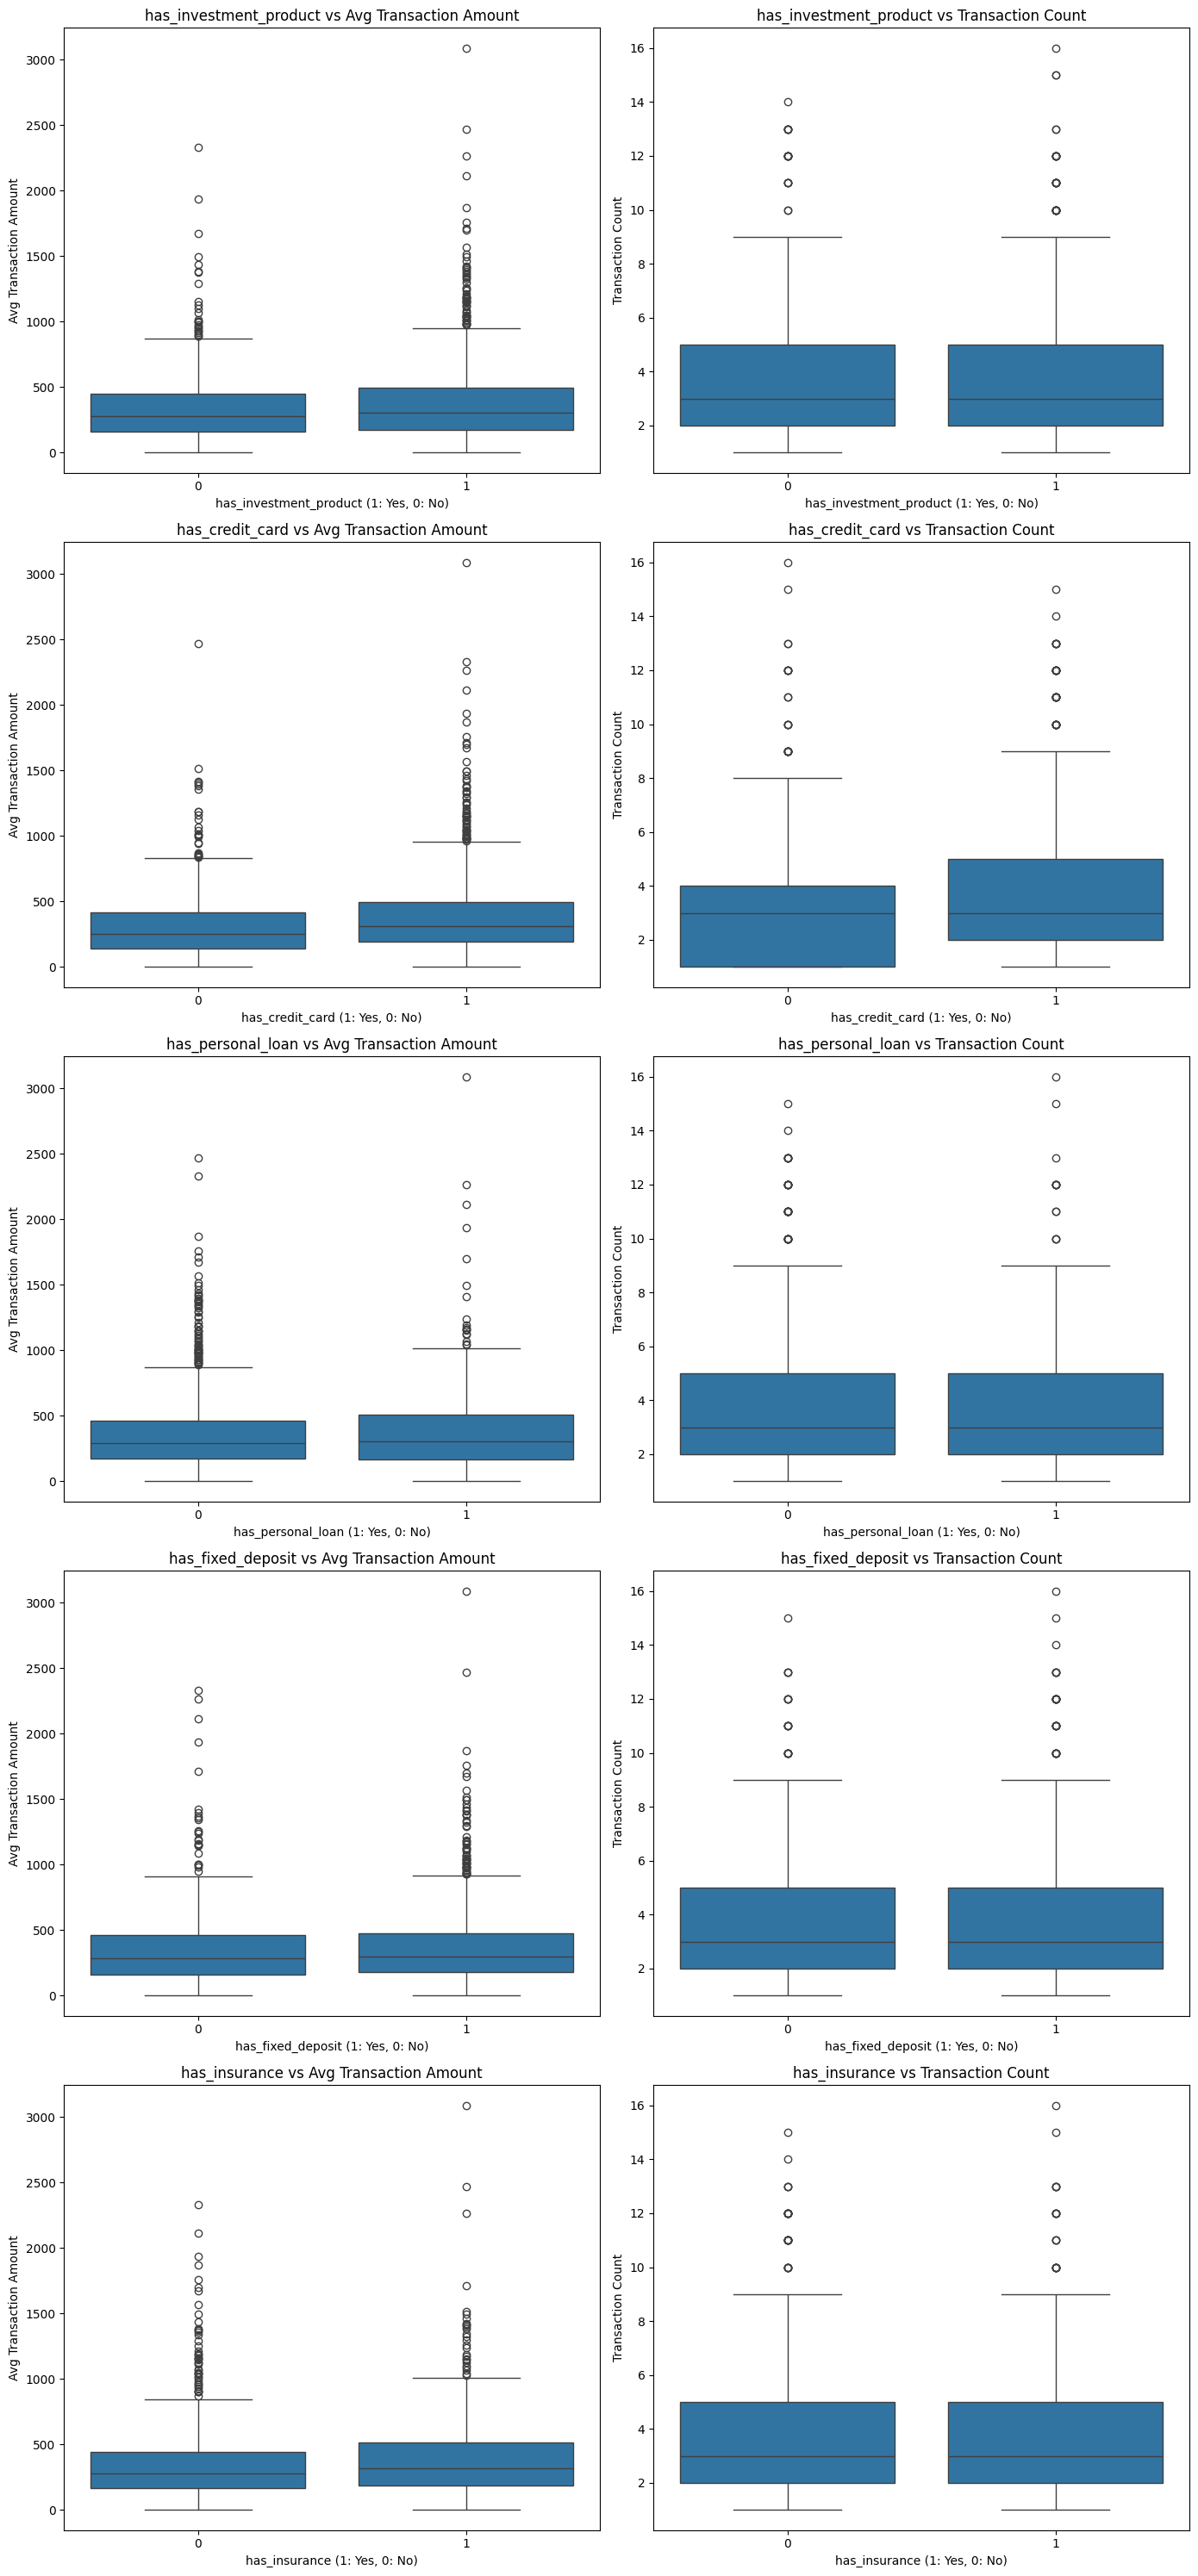

In [8]:
# List of product ownership columns
product_columns = [
    "has_investment_product", "has_credit_card",
    "has_personal_loan", "has_fixed_deposit", "has_insurance"
]

# Plot relationships for each product ownership
fig, axes = plt.subplots(len(product_columns), 2, figsize=(14, 6 * len(product_columns)))

for i, product in enumerate(product_columns):
    # Plot the relationship between product ownership and avg_transaction_amt
    sns.boxplot(x=product, y='avg_transaction_amt', data=merged_data, ax=axes[i, 0])
    axes[i, 0].set_title(f'{product} vs Avg Transaction Amount')
    axes[i, 0].set_xlabel(f'{product} (1: Yes, 0: No)')
    axes[i, 0].set_ylabel('Avg Transaction Amount')
    
    # Plot the relationship between product ownership and transaction_count
    sns.boxplot(x=product, y='transaction_count', data=merged_data, ax=axes[i, 1])
    axes[i, 1].set_title(f'{product} vs Transaction Count')
    axes[i, 1].set_xlabel(f'{product} (1: Yes, 0: No)')
    axes[i, 1].set_ylabel('Transaction Count')

plt.tight_layout()
plt.show()


Transaction data does not significantly differentiate product ownership, suggesting that customers with varying product ownership statuses exhibit similar transaction behaviors. Hence, it lacks predictive power in determining whether a customer holds a specific financial product, and we will omit transaction data to enhance model efficiency and maintain interpretability

#### Loan data vs Product Ownership
Visualise the relationships between each aggregated loan feature with each product to inform feature selection.

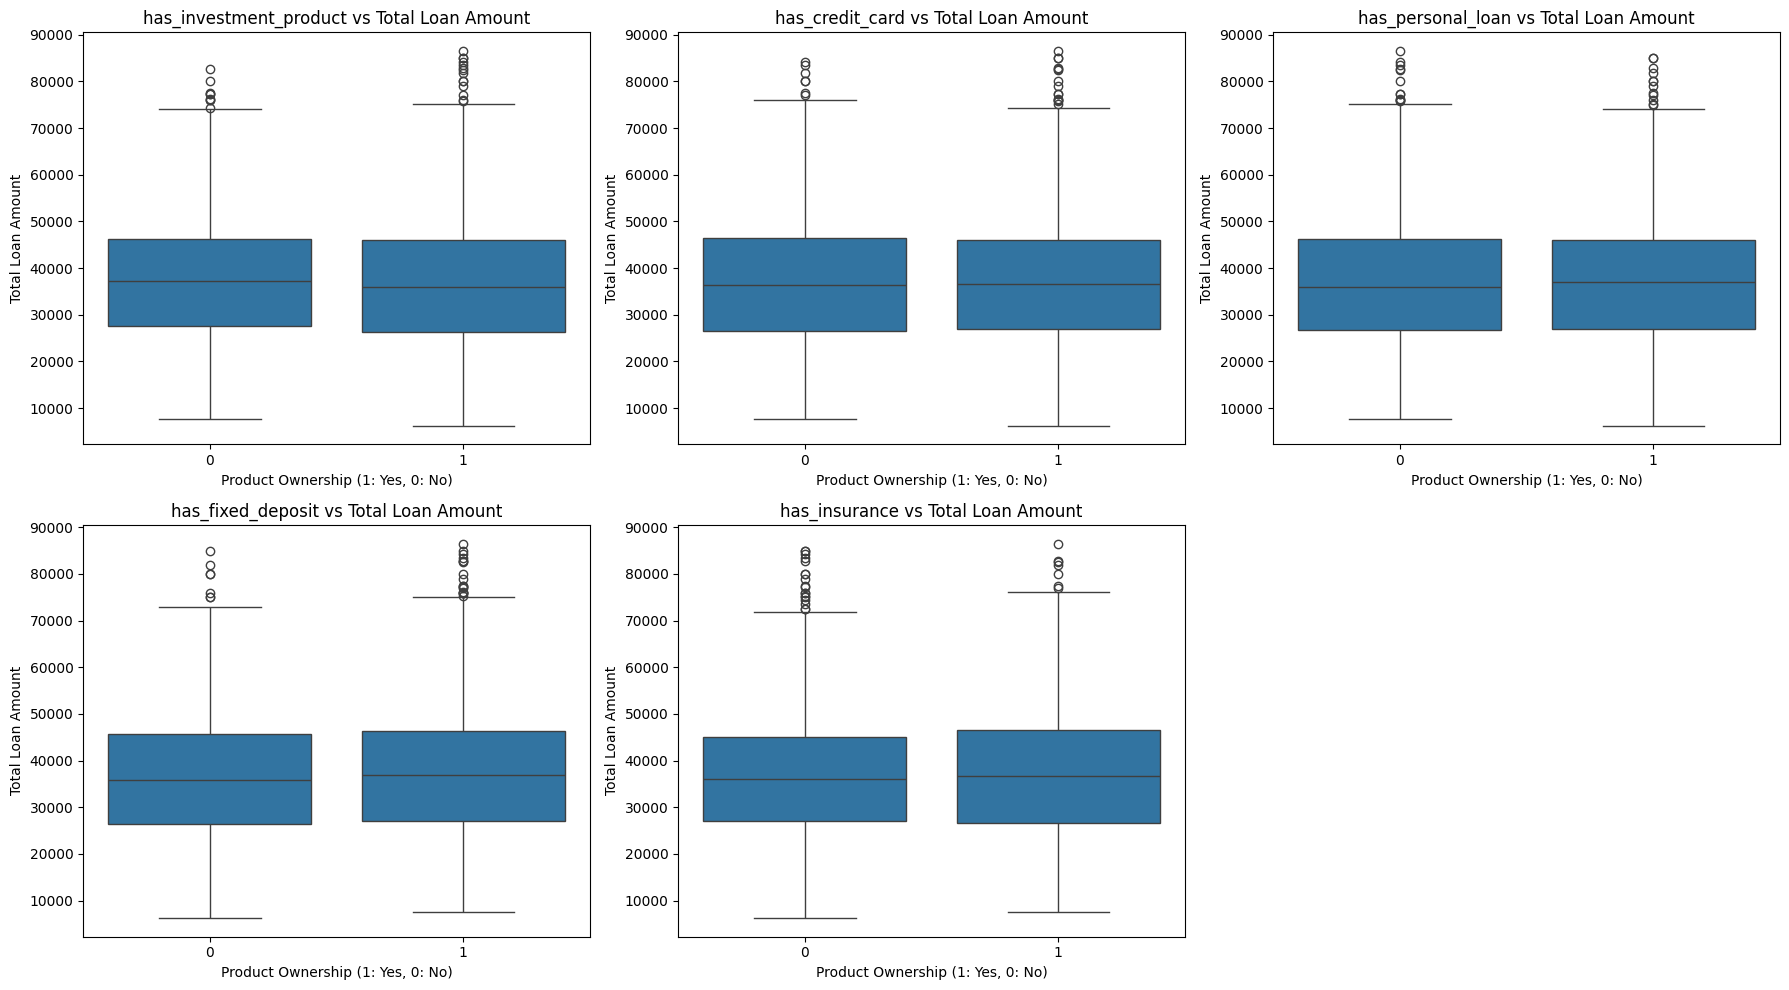

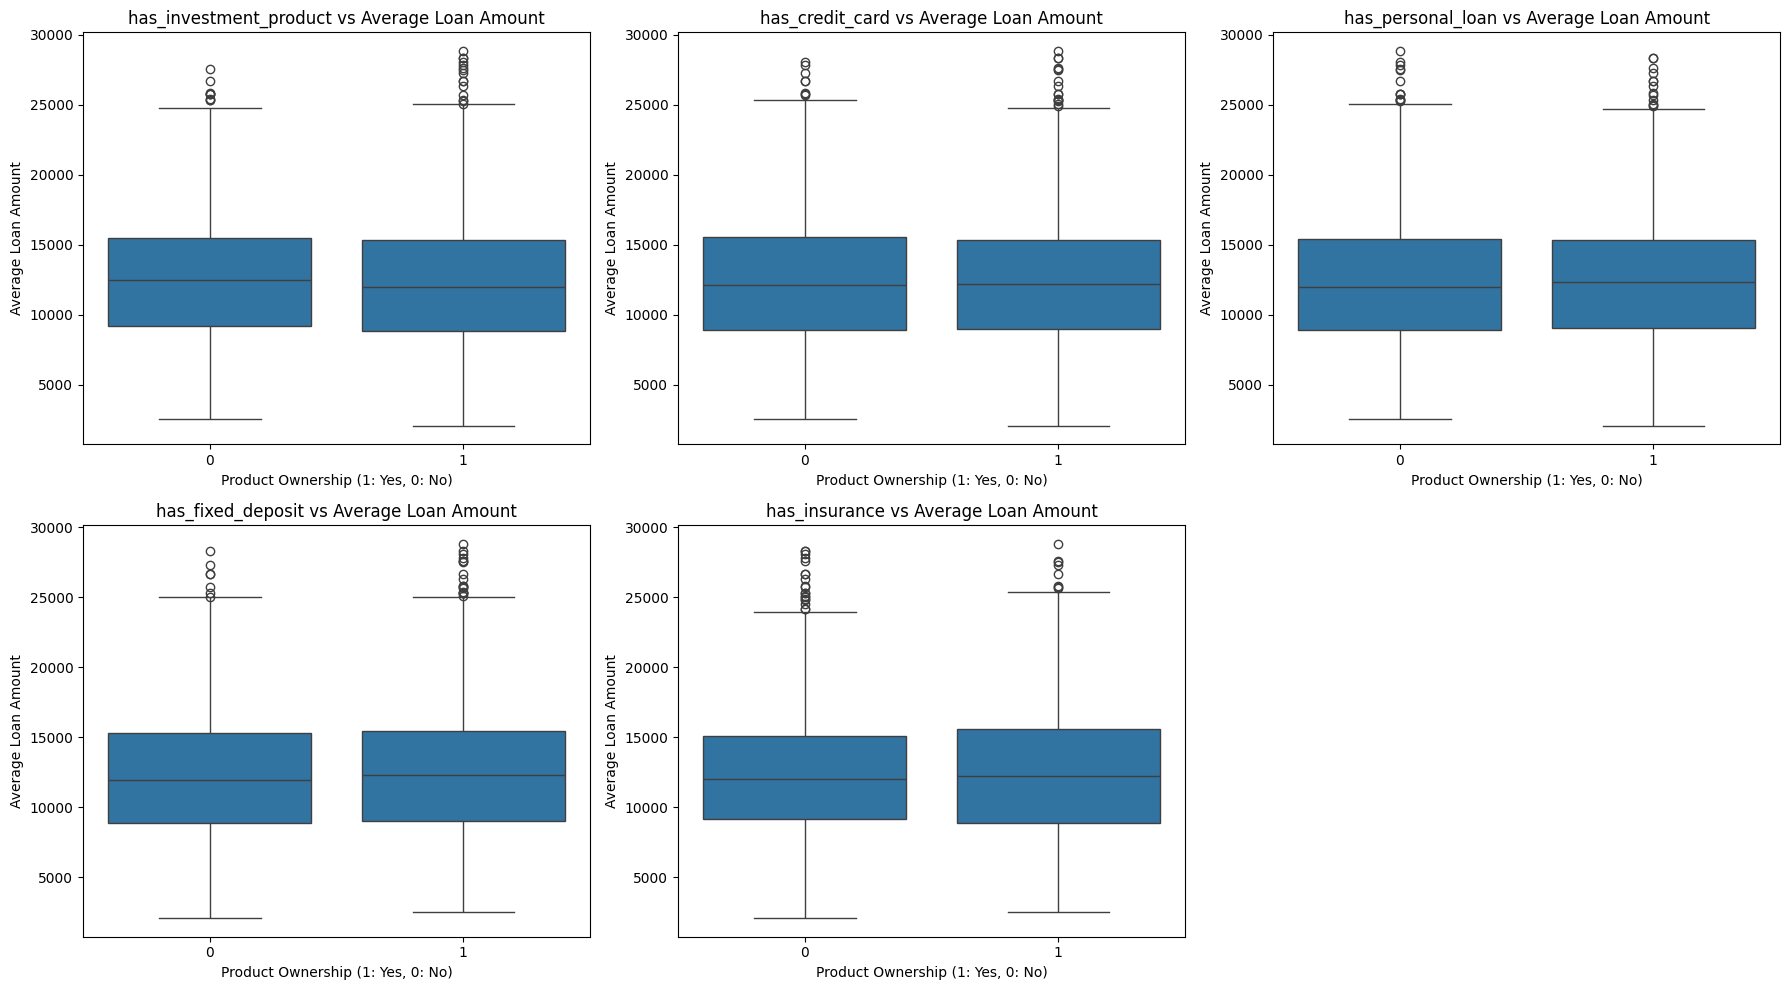

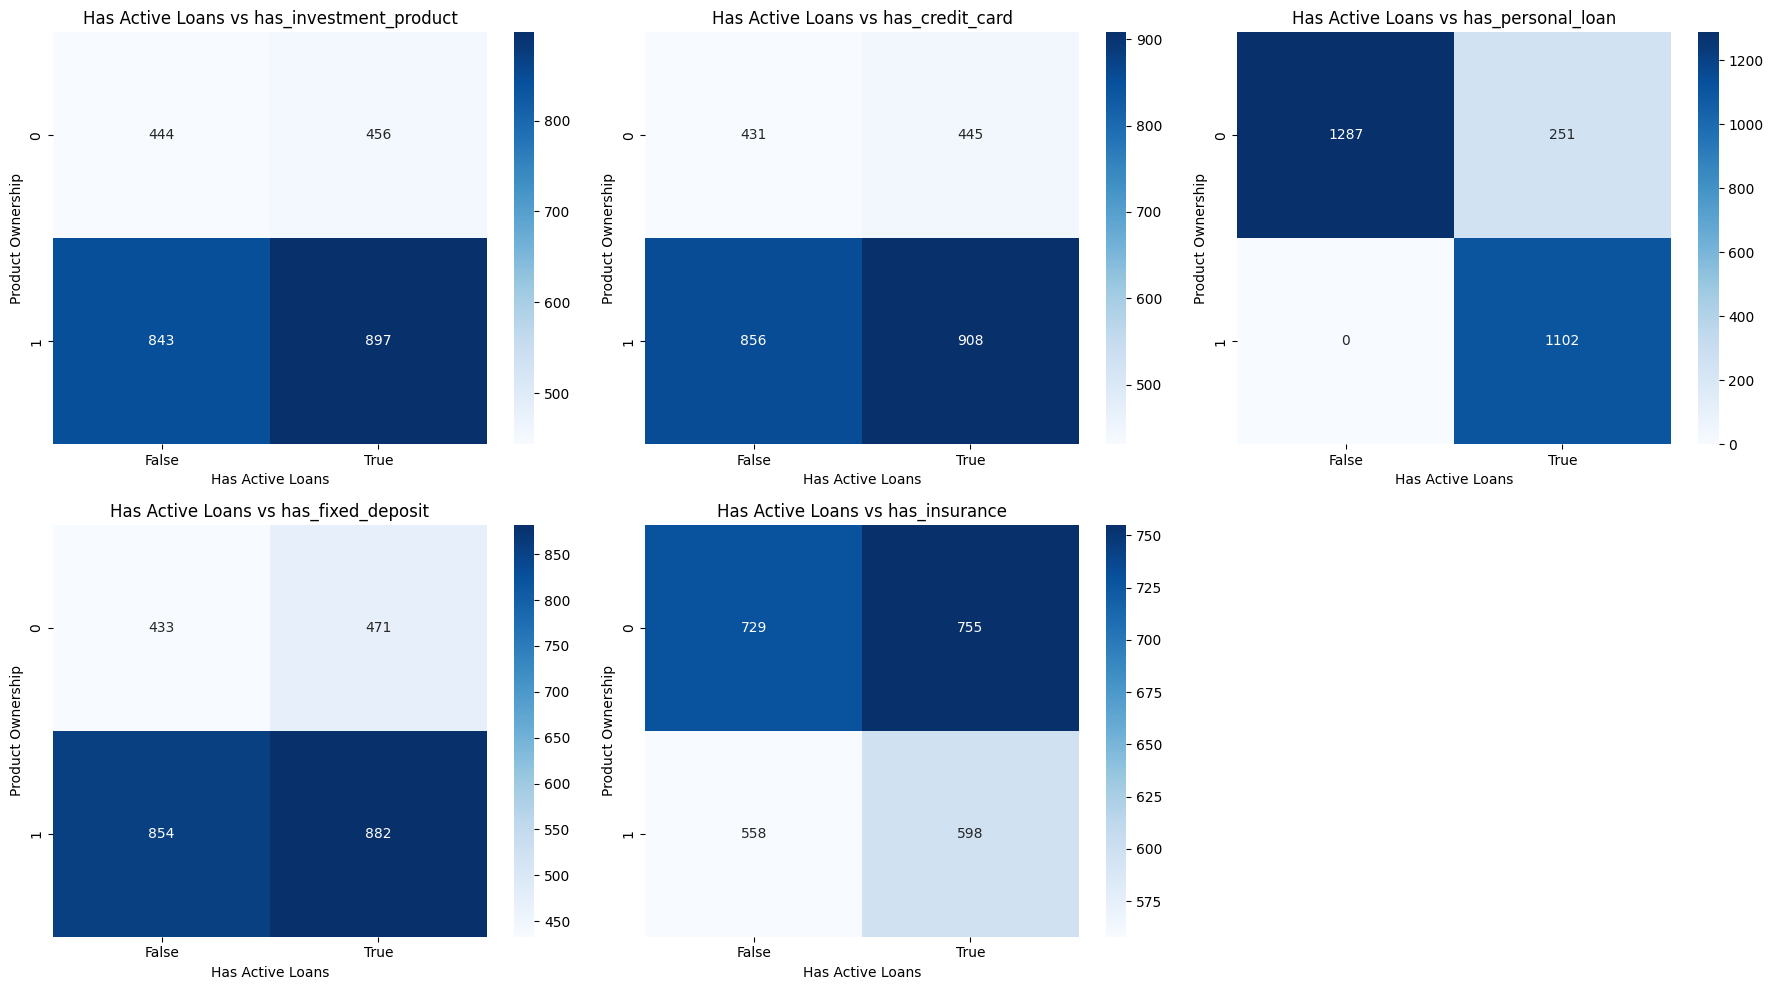

In [9]:
# Define product ownership columns
product_columns = [
    'has_investment_product', 
    'has_credit_card',  
    'has_personal_loan', 
    'has_fixed_deposit', 
    'has_insurance'
]

# Set number of rows and columns for subplots
columns = 3
rows = math.ceil(len(product_columns) / columns)  # Adjust rows dynamically

# 1. Boxplot for Total Loan Amount vs Product Ownership
fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 5))
axes = axes.flatten()  # Flatten in case of single row

for i, product_col in enumerate(product_columns):
    sns.boxplot(x=merged_data[product_col], y=merged_data['total_loan_amount'], ax=axes[i])
    axes[i].set_title(f'{product_col} vs Total Loan Amount')
    axes[i].set_xlabel('Product Ownership (1: Yes, 0: No)')
    axes[i].set_ylabel('Total Loan Amount')

# Hide unused subplots
for i in range(len(product_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# 2. Boxplot for Average Loan Amount vs Product Ownership
fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 5))
axes = axes.flatten()

for i, product_col in enumerate(product_columns):
    sns.boxplot(x=merged_data[product_col], y=merged_data['avg_loan_amount'], ax=axes[i])
    axes[i].set_title(f'{product_col} vs Average Loan Amount')
    axes[i].set_xlabel('Product Ownership (1: Yes, 0: No)')
    axes[i].set_ylabel('Average Loan Amount')

for i in range(len(product_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# 3. Heatmap for Has Active Loans vs Product Ownership
fig, axes = plt.subplots(rows, columns, figsize=(18, rows * 5))
axes = axes.flatten()

for i, product_col in enumerate(product_columns):
    contingency_table_active = pd.crosstab(merged_data[product_col], merged_data['has_active_loans'])
    sns.heatmap(contingency_table_active, annot=True, cmap="Blues", fmt="d", ax=axes[i])
    axes[i].set_title(f'Has Active Loans vs {product_col}')
    axes[i].set_xlabel('Has Active Loans')
    axes[i].set_ylabel('Product Ownership')

for i in range(len(product_columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


Features reflecting loan amount have limited influence on product ownership. This implies that a customer's existing loan size is not a key determinant in their decision to adopt additional financial products. Hence, we will drop total_loan_amount and avg_loan_amount. 
However, we will keep has_active_loans, which appears to be strongly correlated with each product's ownership.

#### Categorical Feature Distributions
Next, we will analyze the distributions of categorical features to identify dominant categories, which may influence our model's predictions.

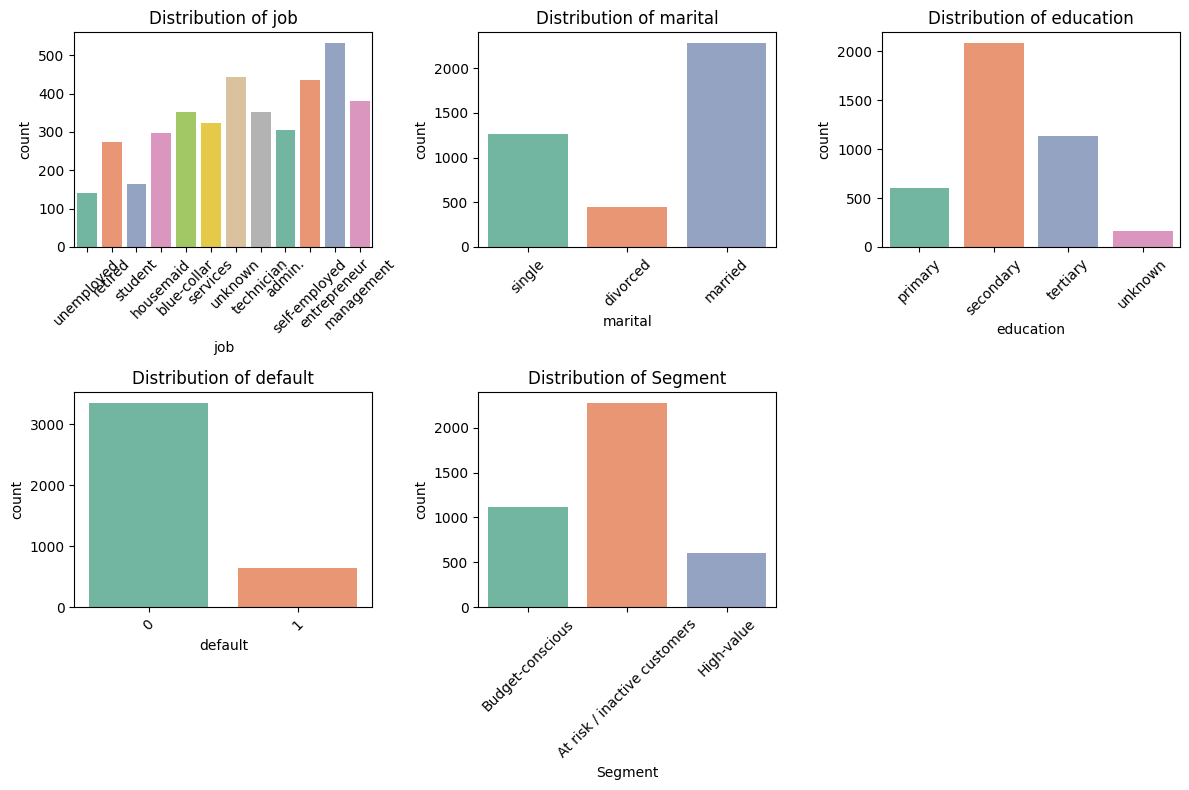

In [10]:
# List of categorical features to analyze
categorical_features = ['job', 'marital', 'education', 'default', 'Segment']

# Plot the distributions of categorical features using bar plots
plt.figure(figsize=(12, 8))

# Loop through each categorical feature to plot
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)  # Adjust number of rows and columns based on your data
    sns.countplot(x=feature, hue=feature, data=df, palette="Set2", legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The default feature exhibits significant class imbalance, with the majority of customers classified as non-default. To assess its predictive value for customer product preferences, we first checked its correlation with the target variables.

In [11]:
# Check correlation between `default` and other target variables
target_columns = ['has_investment_product', 'has_credit_card', 'has_personal_loan', 'has_fixed_deposit', 'has_insurance']
correlations = df[target_columns].apply(lambda x: x.corr(df['default']))

print(correlations)

has_investment_product   -0.027832
has_credit_card          -0.161344
has_personal_loan         0.014154
has_fixed_deposit        -0.021144
has_insurance            -0.026404
dtype: float64


Given that the correlations are very weak and close to zero, it appears that the default feature does not significantly contribute to predicting product ownership. As a result, we have decided to exclude this feature from the model.

#### Dropping features

In [12]:
df = df.drop(columns=['balance', 'default', 'num_loans', 'total_loan_amount', 'avg_loan_amount', 'transaction_count', 'avg_transaction_amt', 'avg_transactions_per_month'])

df.describe()

,customer_id,age,debt,income,dependents,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,39.802000,9.810390,4926.078810,2.339500,0.656500,0.669250,0.275500,0.657000,0.440750
std,1154.844867,10.342608,0.815035,3288.695279,1.299485,0.474936,0.470542,0.446822,0.474771,0.496539
min,1.000000,18.000000,7.831857,200.470000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.750000,32.000000,9.241495,2692.537500,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2000.500000,39.000000,9.819754,4082.075000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,3000.250000,47.000000,10.374081,6256.390000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,4000.000000,77.000000,11.685510,31448.860000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Explore product ownership

We will analyze the distribution of product ownership, as it may provide valuable insights for model selection and guide how we handle the data during the modeling process.

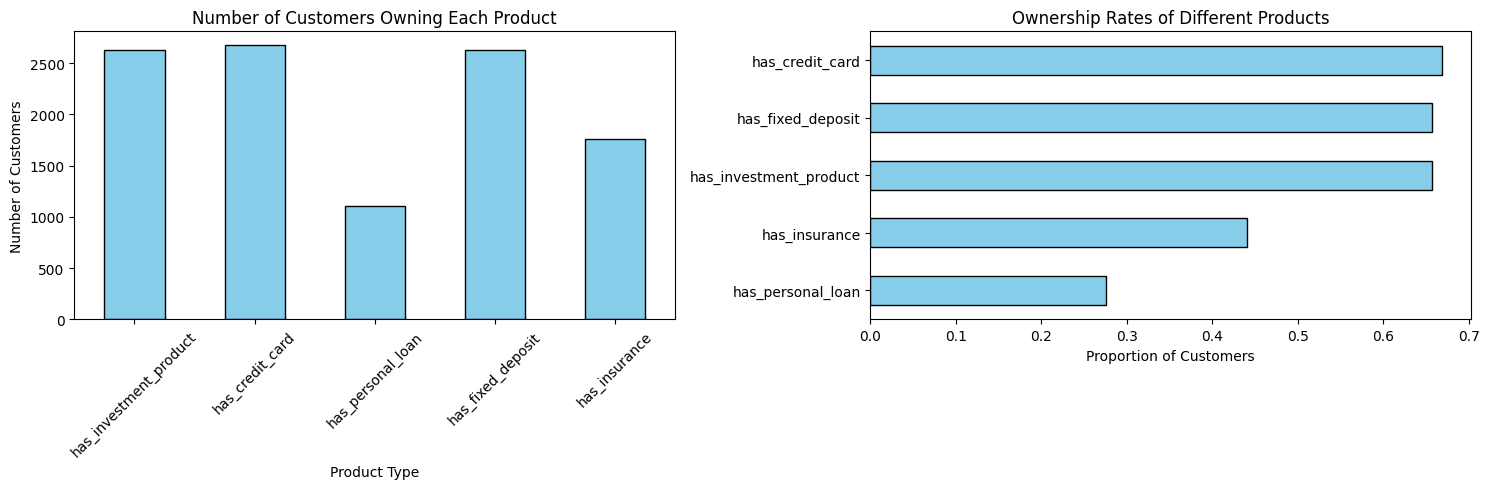

In [13]:
#count customers who have each product
product_counts = products_df.drop(columns=["customer_id"]).sum()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Number of customers owning each product
product_counts.plot(kind="bar", color="skyblue", edgecolor="black", ax=axes[0])
axes[0].set_title("Number of Customers Owning Each Product")
axes[0].set_xlabel("Product Type")
axes[0].set_ylabel("Number of Customers")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Ownership rates of different products
products_df.drop(columns="customer_id").mean().sort_values().plot(kind="barh", ax=axes[1], color="skyblue", edgecolor="black")
axes[1].set_title("Ownership Rates of Different Products")
axes[1].set_xlabel("Proportion of Customers")

# Show the plots
plt.tight_layout()
plt.show()


Given the slight imbalance in the distribution of product ownership, we will leverage tree-based models, such as Random Forest and XGBoost, for our product recommendation system. These models are well-suited for handling class imbalance, as they are less sensitive to skewed class distributions compared to traditional algorithms. 

This reduces the risk of overlooking underrepresented customers, thus enhancing our ability to make more tailored and accurate product recommendations.

# Modeling

Model performance was evaluated using *recall* and the *F1 score*. Maximizing recall ensures that as many potential customers as possible are captured, minimizing missed opportunities. The F1 score, on the other hand, balances recall with precision, helping to avoid excessive irrelevant recommendations. 

After testing both the *Random Forest* and *XGBoost* models, *XGBoost* outperformed Random Forest in handling the class imbalance within product ownership. Furthermore, feature importance analysis revealed that *income*, *education*, and *debt* were less significant in predicting product ownership. Dropping these features improved the model’s performance and enhanced its generalizability.

In [14]:
df = df.drop(columns=['income', 'debt'])
df.describe()

,customer_id,age,dependents,has_investment_product,has_credit_card,has_personal_loan,has_fixed_deposit,has_insurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,39.802000,2.339500,0.656500,0.669250,0.275500,0.657000,0.440750
std,1154.844867,10.342608,1.299485,0.474936,0.470542,0.446822,0.474771,0.496539
min,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.750000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2000.500000,39.000000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,3000.250000,47.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,4000.000000,77.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Define feature and target columns
feature_cols = [
    "age", "job", "education", "dependents", "has_active_loans", "Segment", "marital"   
]

target_cols = [
    "has_investment_product", "has_credit_card",
    "has_personal_loan", "has_fixed_deposit", "has_insurance"
]

X = df[feature_cols]
y = df[target_cols]

# Identify categorical and numerical columns
categorical_features = ['job', 'education', 'Segment', 'marital']
numerical_features = list(set(feature_cols) - set(categorical_features))


In [16]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (e.g., 80% train, 20% test)
df_train, df_test = train_test_split(
    df,
    test_size=0.2,  # 20% for testing
    stratify=df[target_cols[4]],  # Ensures balanced class distribution in target
    random_state=42  # For reproducibility
)

### Model training and evaluation

In [17]:
def evaluate_model(df, target_cols, feature_cols, numerical_features, categorical_features):
    """
    Train and evaluate models using cross-validation for multiple binary targets.

    Parameters:
    - df (pd.DataFrame): The training DataFrame.
    - target_cols (list): List of target column names (binary classification).
    - feature_cols (list): List of feature column names.
    - numerical_features (list): Names of numerical feature columns.
    - categorical_features (list): Names of categorical feature columns.
    - param_grid (dict): Hyperparameter grid for RandomizedSearchCV.

    Returns:
    - performance_df (pd.DataFrame): Average recall, F1-score, and accuracy for each target.
    - best_models (dict): Dict with each target's best model, preprocessor, and threshold.
    """
    
    param_grid = {
        'n_estimators': [50, 100, 500],  # Number of boosting rounds (trees)
        'learning_rate': [0.01, 0.005, 0.05],  # Step size shrinking to prevent overfitting
        'max_depth': [4, 6, 8],  # Maximum depth of a tree
        'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child
        'subsample': [0.7, 0.8, 1.0],  # Fraction of samples to be used for each tree
        'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features used for each tree
        'gamma': [0.1, 0.2, 0.3],  # Minimum loss reduction required to make a further partition
    }
    preprocessor = ColumnTransformer(transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numerical_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ])

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    performance_metrics_all_targets = []
    best_models = {}

    for target in target_cols:
        X = df[feature_cols]
        y = df[target]
        
        neg_samples = (y == 0).sum()
        pos_samples = (y == 1).sum()
        scale_pos_weight = neg_samples / pos_samples if pos_samples != 0 else 1
        print(f"Scale Pos Weight for {target}: {scale_pos_weight}")
        
        X_processed = preprocessor.fit_transform(X)

        recall_list = []
        f1_list = []
        accuracy_list = []
        best_thresholds = []

        for train_idx, val_idx in kf.split(X_processed, y):
            X_train, X_val = X_processed[train_idx], X_processed[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            target_param_grid = param_grid.copy()
            target_param_grid['scale_pos_weight'] = [scale_pos_weight]

            random_search = RandomizedSearchCV(
                estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
                param_distributions=target_param_grid,
                n_iter=10,
                scoring='accuracy',
                cv=3,
                verbose=0,
                n_jobs=-1,
                random_state=42
            )

            random_search.fit(X_train, y_train)
            best_model = random_search.best_estimator_

            y_pred_proba = best_model.predict_proba(X_val)[:, 1]
            precision_vals, recall_vals, thresholds = precision_recall_curve(y_val, y_pred_proba)
            f1_scores = (2 * precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-6)
            best_threshold = thresholds[np.argmax(f1_scores)]

            y_pred = (y_pred_proba > best_threshold).astype(int)
            precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average='binary')
            accuracy = accuracy_score(y_val, y_pred)

            recall_list.append(recall)
            f1_list.append(f1)
            accuracy_list.append(accuracy)
            best_thresholds.append(best_threshold)

        performance_metrics_all_targets.append({
            "Target": target,
            "Average Recall": np.mean(recall_list),
            "Average F1-Score": np.mean(f1_list),
            "Average Accuracy": np.mean(accuracy_list),
        })

        # Store the preprocessor, best model, and average best threshold for future prediction use
        best_models[target] = {
            "preprocessor": preprocessor,
            "model": best_model,
            "threshold": np.mean(best_thresholds)
        }

    performance_df = pd.DataFrame(performance_metrics_all_targets)
    return performance_df, best_models

performance_df, best_models = evaluate_model(
    df=df_train,
    target_cols=target_cols,
    feature_cols=feature_cols,
    numerical_features=numerical_features,
    categorical_features=categorical_features
)

print(performance_df)

Scale Pos Weight for has_investment_product: 0.5303682448589192


c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Scale Pos Weight for has_credit_card: 0.4925373134328358


c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Scale Pos Weight for has_personal_loan: 2.615819209039548


c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Scale Pos Weight for has_fixed_deposit: 0.5115729806329712


c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Scale Pos Weight for has_insurance: 1.2695035460992907


c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                   Target  Average Recall  Average F1-Score  Average Accuracy
0  has_investment_product        0.998087          0.789932          0.653125
1         has_credit_card        0.917910          0.834482          0.755942
2       has_personal_loan        0.995480          0.901359          0.939687
3       has_fixed_deposit        0.998583          0.795634          0.660625
4           has_insurance        0.813475          0.676048          0.656563


c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [00:45:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Feature importance

In [21]:
def get_feature_importance(best_models, feature_cols, top_n=10, plot=True):
    """
    Extract and optionally plot the top N feature importances for each target.

    Parameters:
    - best_models (dict): Output from evaluate_model() containing model and preprocessor per target.
    - feature_cols (list): Original feature columns.
    - top_n (int): Number of top features to display.
    - plot (bool): Whether to plot the feature importances.

    Returns:
    - feature_importance_dict (dict): Dict of DataFrames with feature importances per target.
    """
    feature_importance_dict = {}

    for target, components in best_models.items():
        model = components["model"]
        preprocessor = components["preprocessor"]

        # Get transformed feature names (after one-hot encoding)
        try:
            ohe = preprocessor.named_transformers_['cat'].named_steps['encoder']
            cat_features = preprocessor.transformers_[1][2]
            ohe_feature_names = ohe.get_feature_names_out(cat_features)
        except:
            ohe_feature_names = []

        num_features = preprocessor.transformers_[0][2]
        all_features = list(num_features) + list(ohe_feature_names)

        # Match feature importances with feature names
        importance = model.feature_importances_
        importance_df = pd.DataFrame({
            "Feature": all_features,
            "Importance": importance
        }).sort_values(by="Importance", ascending=False).head(top_n)

        feature_importance_dict[target] = importance_df

        # Optional: plot
        if plot:
            plt.figure(figsize=(8, 5))
            plt.barh(importance_df["Feature"][::-1], importance_df["Importance"][::-1])
            plt.xlabel("Importance")
            plt.title(f"Top {top_n} Feature Importances for Target: {target}")
            plt.tight_layout()
            plt.show()

    return feature_importance_dict

# After training using evaluate_model()
feature_importance_dict = get_feature_importance(
    best_models=best_models,
    feature_cols=feature_cols,
    top_n=10,
    plot=False  # Set to False if you only want data, not plots
)

feature_importance_dict

{'has_investment_product':                Feature  Importance
 7       job_management    0.052814
 11         job_student    0.051300
 3           job_admin.    0.050592
 21  Segment_High-value    0.047152
 18   education_unknown    0.043776
 14         job_unknown    0.043105
 13      job_unemployed    0.041673
 6        job_housemaid    0.040648
 17  education_tertiary    0.040111
 10        job_services    0.039990,
 'has_credit_card':                                  Feature  Importance
 2                                    age    0.344798
 21                    Segment_High-value    0.035410
 11                           job_student    0.035141
 8                            job_retired    0.031927
 19  Segment_At risk / inactive customers    0.031362
 20              Segment_Budget-conscious    0.030166
 4                        job_blue-collar    0.029912
 5                       job_entrepreneur    0.029337
 7                         job_management    0.028881
 1                

### Predicting using the trained model

In [19]:
def predict_with_best_model(df, feature_cols, best_models):
    """
    Predict binary labels for each target using the best trained models.

    Parameters:
    - df (pd.DataFrame): The test DataFrame.
    - feature_cols (list): Feature column names.
    - best_models (dict): Output from evaluate_model() with models and thresholds.

    Returns:
    - predictions_df (pd.DataFrame): Predicted labels for each target.
    """

    predictions = {}

    for target, components in best_models.items():
        X = df[feature_cols]
        preprocessor = components['preprocessor']
        model = components['model']
        threshold = components['threshold']

        X_processed = preprocessor.transform(X)
        y_pred_proba =model.predict_proba(X_processed)[:, 1]
        y_pred = (y_pred_proba > threshold).astype(int)

        predictions[target] = y_pred

    predictions_df = pd.DataFrame(predictions)
    return predictions_df

# Replace df_test with your actual test set
predictions_df = predict_with_best_model(df_test, feature_cols, best_models)
predictions_df.to_csv("../product_recommendations.csv", index=False)
print(predictions_df.head())

   has_investment_product  has_credit_card  has_personal_loan  \
0                       1                0                  1   
1                       1                1                  0   
2                       1                1                  0   
3                       1                1                  0   
4                       1                1                  0   

   has_fixed_deposit  has_insurance  
0                  1              1  
1                  1              0  
2                  1              1  
3                  1              0  
4                  1              1  
